In [1]:
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.3 MB/s eta 0:00:00


In [2]:
# Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from keras import Sequential
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

# System Libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Model
from tensorflow.keras.applications import MobileNetV2,ResNet50, ResNet50V2

# Extra
from termcolor import colored

In [3]:
!ls "/kaggle/input/dataset"
dir = "/kaggle/input/dataset"

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


AI_SD_art_nouveau    AI_SD_renaissance	baroque        romanticism
AI_SD_baroque	     AI_SD_romanticism	expressionism  surrealism
AI_SD_expressionism  AI_SD_surrealism	impressionism  ukiyo_e
AI_SD_impressionism  AI_SD_ukiyo-e	realism
AI_SD_realism	     art_nouveau	renaissance


Number of classes in Directory folder: 18


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


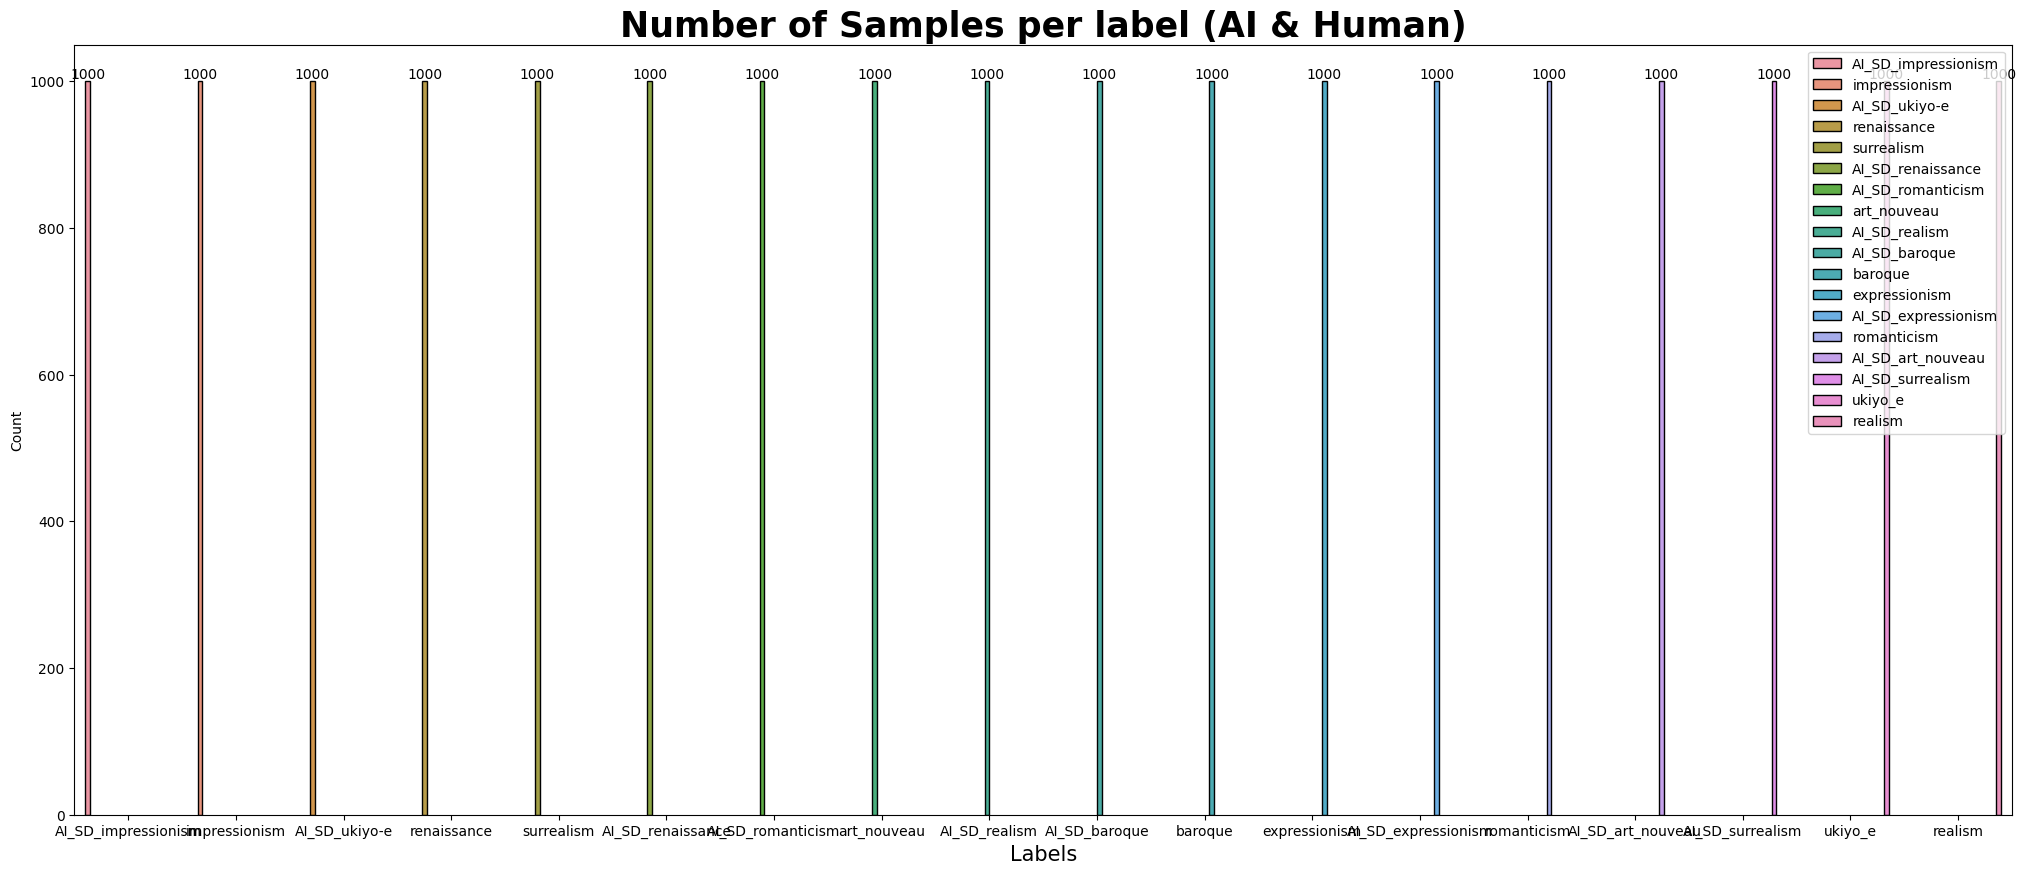

In [4]:
def num_of_classes(folder_dir, folder_name):
  classes = [class_name for class_name in os.listdir(dir)]
  print(colored(f'Number of classes in {folder_name} folder: {len(classes)}', 'green', attrs = ['bold']))
num_of_classes(dir, 'Directory')

classes = [class_name for class_name in os.listdir(dir)]
count = []

for class_name in classes:
  count.append(len(os.listdir(os.path.join(dir, class_name))))

plt.figure(figsize = (25, 10))
ax = sns.barplot(x = classes, y = count, hue = classes, edgecolor = 'black')

for i in ax.containers:
  ax.bar_label(i, )

plt.title('Number of Samples per label (AI & Human)', fontsize = 25, fontweight = 'bold')
plt.xlabel('Labels', fontsize = 15)
plt.ylabel('Count')
plt.show()

In [5]:
# def create_df(folder_path, max_images_per_class=100):
#     all_images = []
#     for class_name in classes:
#         class_path = os.path.join(folder_path, class_name)
#         class_images = [(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)]

#         # Limit the number of images per class to max_images_per_class
#         all_images.extend(class_images[:max_images_per_class])

#     df = pd.DataFrame(all_images, columns=['file_path', 'label'])
#     return df

# dataset = create_df(dir)
allowed_classes = [
    'AI_SD_art_nouveau', 'AI_SD_baroque', 'AI_SD_expressionism', 'AI_SD_impressionism',
    'AI_SD_realism', 'AI_SD_renaissance', 'AI_SD_romanticism', 'AI_SD_surrealism', 'AI_SD_ukiyo-e',
    'art_nouveau', 'surrealism', 'baroque', 'ukiyo_e', 'expressionism', 'impressionism',
    'realism', 'renaissance', 'romanticism'
]

def create_filtered_df(folder_path, max_images_per_class=1000):
    all_images = []
    for class_name in allowed_classes:
        class_path = os.path.join(folder_path, class_name)

        if os.path.exists(class_path):
            class_images = [(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)]

            all_images.extend(class_images[:max_images_per_class])

    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

dataset = create_filtered_df(dir)
dataset

file_path              label
0      /kaggle/input/dataset/AI_SD_art_nouveau/0-2339...  AI_SD_art_nouveau
1      /kaggle/input/dataset/AI_SD_art_nouveau/0-1612...  AI_SD_art_nouveau
2      /kaggle/input/dataset/AI_SD_art_nouveau/0-1594...  AI_SD_art_nouveau
3      /kaggle/input/dataset/AI_SD_art_nouveau/0-1696...  AI_SD_art_nouveau
4      /kaggle/input/dataset/AI_SD_art_nouveau/0-2165...  AI_SD_art_nouveau
...                                                  ...                ...
17995  /kaggle/input/dataset/romanticism/thomas-sully...        romanticism
17996  /kaggle/input/dataset/romanticism/karoly-lotz_...        romanticism
17997  /kaggle/input/dataset/romanticism/william-turn...        romanticism
17998  /kaggle/input/dataset/romanticism/miklos-barab...        romanticism
17999  /kaggle/input/dataset/romanticism/jan-matejko_...        romanticism

[18000 rows x 2 columns]

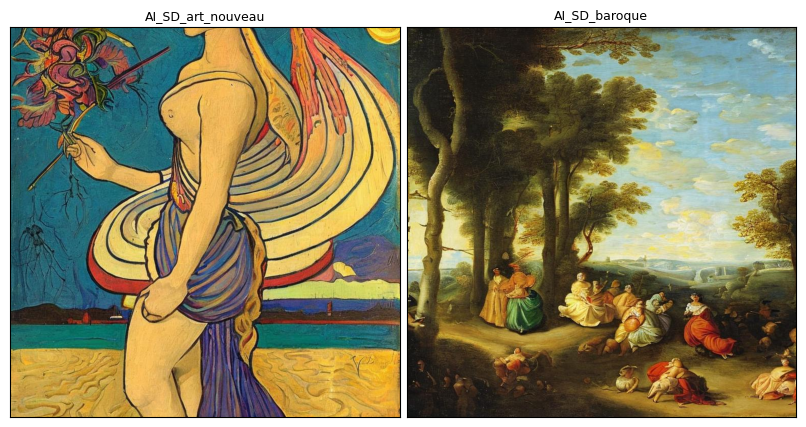

In [6]:
df_unique = dataset.copy().drop_duplicates(subset = ['label']).reset_index()

fig, axes = plt.subplots(1, 2, figsize = (8, 7),
                         subplot_kw = {'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(df_unique.file_path[i]))
  ax.set_title(df_unique.label[i], fontsize = 9)
plt.tight_layout(pad = 0.5)
plt.show()

In [7]:
train, test = train_test_split(dataset, test_size = 0.2, random_state = 0)
val, test = train_test_split(test, test_size = 0.5, random_state = 0)

In [8]:
TARGET_SIZE = (256, 256)
BATCH_SIZE = 32

In [9]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    shear_range = 0.1,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_dataframe(
  dataframe = train,
  x_col = 'file_path',
  y_col = 'label',
  target_size = TARGET_SIZE,
  color_mode = 'rgb',
  class_mode = 'categorical',
  batch_size = BATCH_SIZE,
  shuffle = True,
  seed = 42
)

Found 14400 validated image filenames belonging to 18 classes.


In [10]:
#Validation Generator
val_datagen = ImageDataGenerator(rescale=1./255,)

val_generator = val_datagen.flow_from_dataframe(
  dataframe = val,
  x_col = 'file_path',
  y_col = 'label',
  target_size = TARGET_SIZE,
  color_mode = 'rgb',
  class_mode = 'categorical',
  batch_size = BATCH_SIZE,
  shuffle = False,
  seed = 42
)

Found 1800 validated image filenames belonging to 18 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale=1. / 255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    x_col = 'file_path',
    y_col = 'label',
    target_size = TARGET_SIZE,
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    seed = 42,
    shuffle = False
)

Found 1800 validated image filenames belonging to 18 classes.


In [12]:
from tensorflow.keras.layers import Lambda
# Load the Xception base model without the top (classification) layer
base_model = tf.keras.applications.Xception(include_top=False, pooling='avg', input_shape=(256, 256, 3))

# Freeze the layers in the base model
base_model.trainable = False

# Build Model
model = Sequential()
model.add(Lambda(lambda x: x, input_shape=(256, 256, 3)))

# Base Model
model.add(base_model)

# Batch Normalization
model.add(BatchNormalization())

# Dropout Layer
model.add(Dropout(0.45))

# Dense Layer 1
model.add(Dense(220, activation='relu'))

# Dropout Layer
model.add(Dropout(0.25))

# Dense Layer 2
model.add(Dense(60,activation='relu'))

# Output Layer
model.add(Dense(18, activation='softmax'))

# Compile
model.compile(optimizer = Adam(learning_rate=0.001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 220)            │       450,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 220)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │        13,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 18)             │         1,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,334,810 (81.39 MB)

 Trainable params: 469,234 (1.79 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

In [13]:
# Early Stopping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')

# ReduceLRonPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 10, min_lr = 1e-6)

In [14]:
history = model.fit(
    train_generator,
    epochs = 50,
    validation_data = val_generator,
    callbacks = [earlystop_cb, reduce_lr],
    batch_size = 32
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728995848.096716     152 service.cc:145] XLA service 0x7ce87c003730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728995848.096782     152 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/450 ━━━━━━━━━━━━━━━━━━━━ 46s 103ms/step - accuracy: 0.0859 - loss: 3.6941  

I0000 00:00:1728995859.199060     152 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


450/450 ━━━━━━━━━━━━━━━━━━━━ 383s 801ms/step - accuracy: 0.4494 - loss: 1.8164 - val_accuracy: 0.6500 - val_loss: 0.9887 - learning_rate: 0.0010
Epoch 2/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 307s 672ms/step - accuracy: 0.6156 - loss: 1.1116 - val_accuracy: 0.6639 - val_loss: 0.9403 - learning_rate: 0.0010
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 315s 689ms/step - accuracy: 0.6364 - loss: 1.0520 - val_accuracy: 0.6811 - val_loss: 0.8980 - learning_rate: 0.0010
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 314s 687ms/step - accuracy: 0.6485 - loss: 0.9877 - val_accuracy: 0.6861 - val_loss: 0.8675 - learning_rate: 0.0010
Epoch 5/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 315s 689ms/step - accuracy: 0.6592 - loss: 0.9686 - val_accuracy: 0.6883 - val_loss: 0.8439 - learning_rate: 0.0010
Epoch 6/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 315s 690ms/step - accuracy: 0.6646 - loss: 0.9421 - val_accuracy: 0.6978 - val_loss: 0.8651 - learning_rate: 0.0010
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 308s 674ms/step - accuracy: 0.6754 

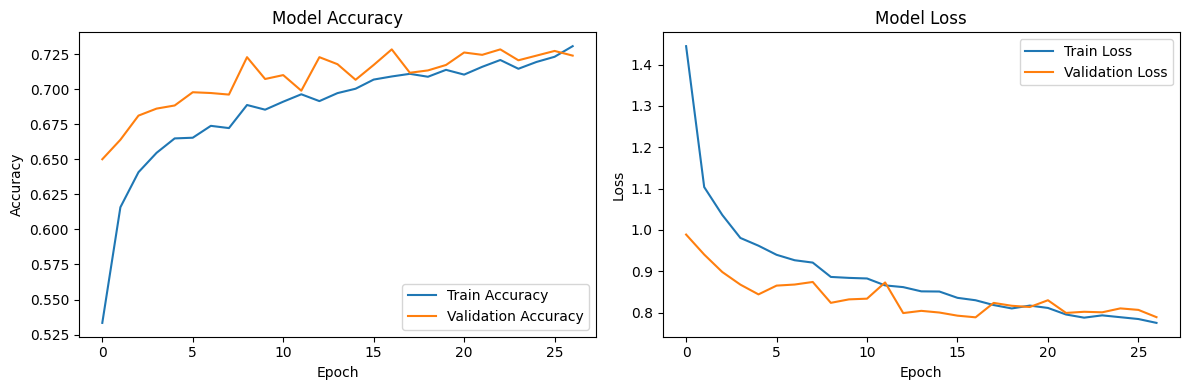

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [16]:
model.evaluate(test_generator)

57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 287ms/step - accuracy: 0.7216 - loss: 0.8042


[0.8240936398506165, 0.7172222137451172]

57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 159ms/step


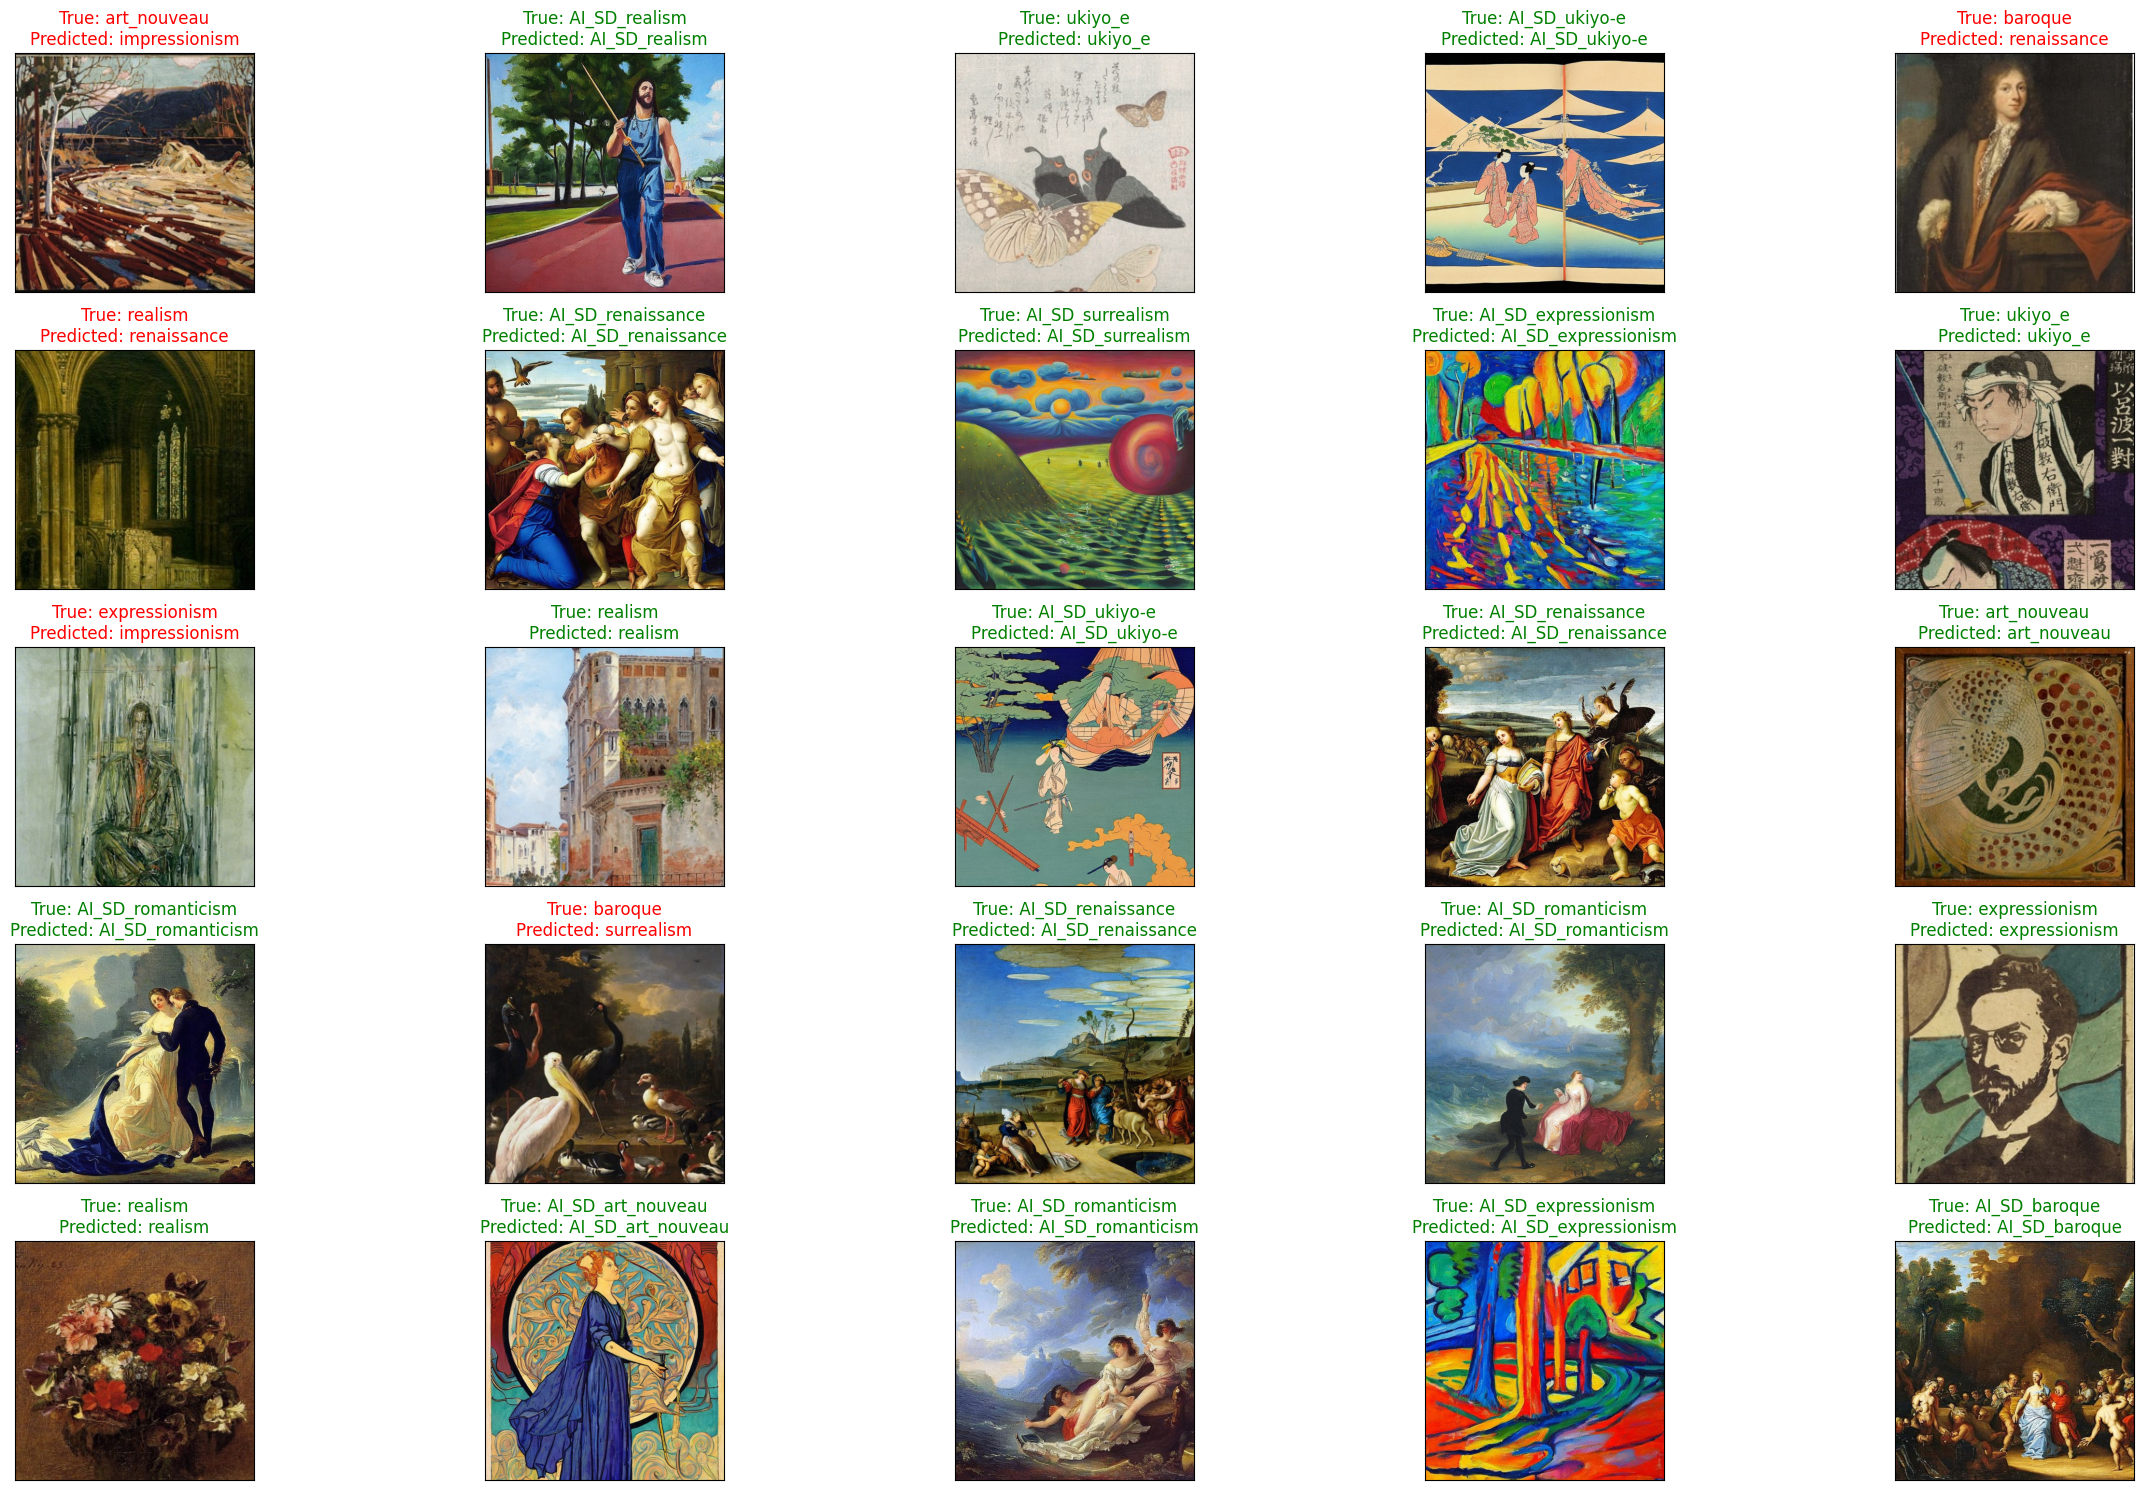

In [17]:
num_images = len(test)  # Assuming `test_dataset` is a pandas DataFrame with the test data

class_labels = list(train_generator.class_indices.keys())

# Getting all the true labels for the validation set
true_labels = test_generator.classes

# To get the predicted labels, we predict using the model
predictions = model.predict(test_generator, steps=len(test_generator))

# Take the argmax to get the predicted class indices.
predicted_labels = np.argmax(predictions, axis=1)

random_index = np.random.randint(0, len(test) - 1, num_images)
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 15),
                             subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
        # Replace 'file_path' and 'class_label' with the correct column names for image paths and labels
        img_path = test['file_path'].iloc[random_index[i]]
        true_label = test['label'].iloc[random_index[i]]

        # Get the predicted class index and map it to the class name
        pred_index = predicted_labels[random_index[i]]
        pred_label = class_labels[pred_index]  # Convert the index to the class name

        # Display the image
        ax.imshow(plt.imread(img_path))

        # Determine the color of the title based on prediction accuracy
        if true_label == pred_label:
            color = "green"
        else:
            color = "red"

        # Set title showing true and predicted class names
        ax.set_title(f"True: {true_label}\nPredicted: {pred_label}", color=color)

plt.tight_layout()
plt.show()

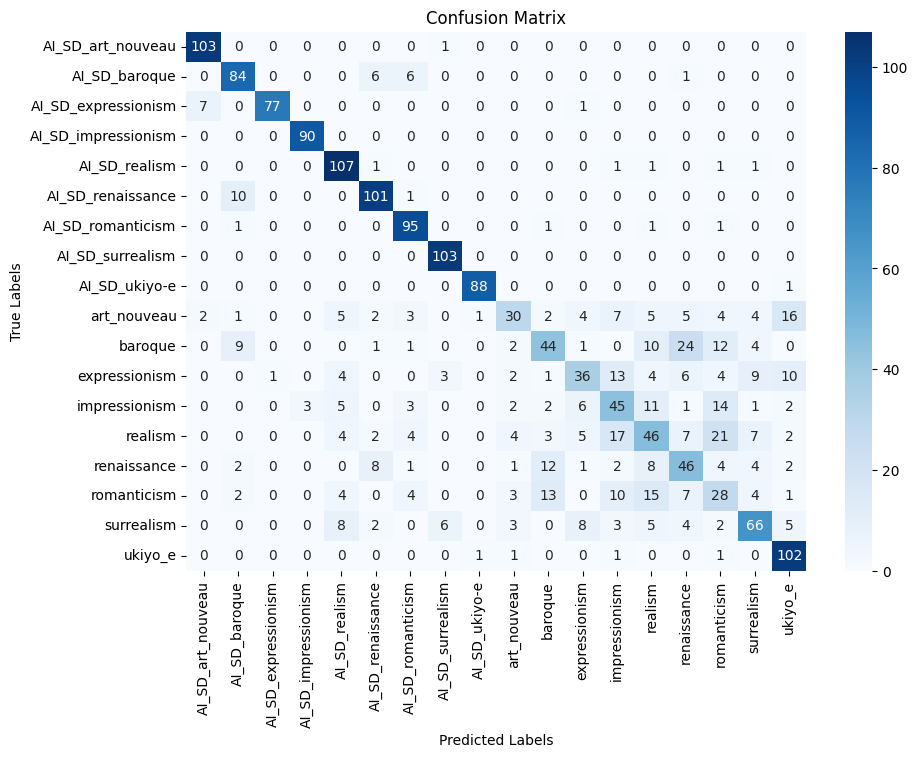

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

true_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)
cm = confusion_matrix(true_labels, predicted_labels)
class_names = list(train_generator.class_indices.keys())  # Ensure this is the correct order

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()